### Flight Price Prediction¶
Problem Statement: Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

Size of training set: 10683 records

Size of test set: 2671 records

FEATURES: Airline: The name of the airline.

Date_of_Journey: The date of the journey

Source: The source from which the service begins.

Destination: The destination where the service ends.

Route: The route taken by the flight to reach the destination.

Dep_Time: The time when the journey starts from the source.

Arrival_Time: Time of arrival at the destination.

Duration: Total duration of the flight.

Total_Stops: Total stops between the source and destination.

Additional_Info: Additional information about the flight

Price: The price of the ticket

You have to use your skills as a data scientist and build a machine learning model to predict the price of the flight ticket.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
import pickle as pkl

In [2]:
df1= pd.read_excel('Data_Train.xlsx')
df2= pd.read_excel('Test_set.xlsx')
df = pd.concat([df1,df2]).reset_index(drop=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(df.tail())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
13349,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,NaN
13350,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,NaN
13351,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,NaN
13352,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,NaN
13353,Multiple carriers,15/06/2019,Delhi,Cochin,DEL → BOM → COK,04:55,19:15,14h 20m,1 stop,No info,NaN


In [3]:
df.shape

(13354, 11)

In [16]:
df['Airline'].nunique()

12

In [4]:
df['Date'] = pd.to_datetime(df.Date_of_Journey, format='%d/%m/%Y')
df['Weekday'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df['Duration'] = df['Duration'].str.replace("h",'*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
df['Flight_Charting'] = df['Source'] + ' to ' + df['Destination']
df['Arrival_Hour'] = df['Arrival_Time'].str.split(':').str[0]
df['Dep_Hour'] = df['Dep_Time'].str.split(':').str[0]
df['Day'] = df['Date_of_Journey'].str.split('/').str[0]

In [5]:
df3 = df.drop(['Date_of_Journey','Source','Arrival_Time','Destination','Dep_Time','Route','Date'],axis=1)

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Duration         13354 non-null  int64  
 2   Total_Stops      13353 non-null  object 
 3   Additional_Info  13354 non-null  object 
 4   Price            10683 non-null  float64
 5   Weekday          13354 non-null  object 
 6   Month            13354 non-null  object 
 7   Flight_Charting  13354 non-null  object 
 8   Arrival_Hour     13354 non-null  object 
 9   Dep_Hour         13354 non-null  object 
 10  Day              13354 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ MB


In [29]:
[i for i in df3.columns if df3[i].isnull().sum()>0]

['Total_Stops', 'Price']

In [7]:
Missing_Data = ['Total_Stops', 'Price']

In [8]:
for i in Missing_Data:
    df3[i] = df3[i].fillna(df3[i].dropna().mode()[0])

In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Duration         13354 non-null  int64  
 2   Total_Stops      13354 non-null  object 
 3   Additional_Info  13354 non-null  object 
 4   Price            13354 non-null  float64
 5   Weekday          13354 non-null  object 
 6   Month            13354 non-null  object 
 7   Flight_Charting  13354 non-null  object 
 8   Arrival_Hour     13354 non-null  object 
 9   Dep_Hour         13354 non-null  object 
 10  Day              13354 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ MB


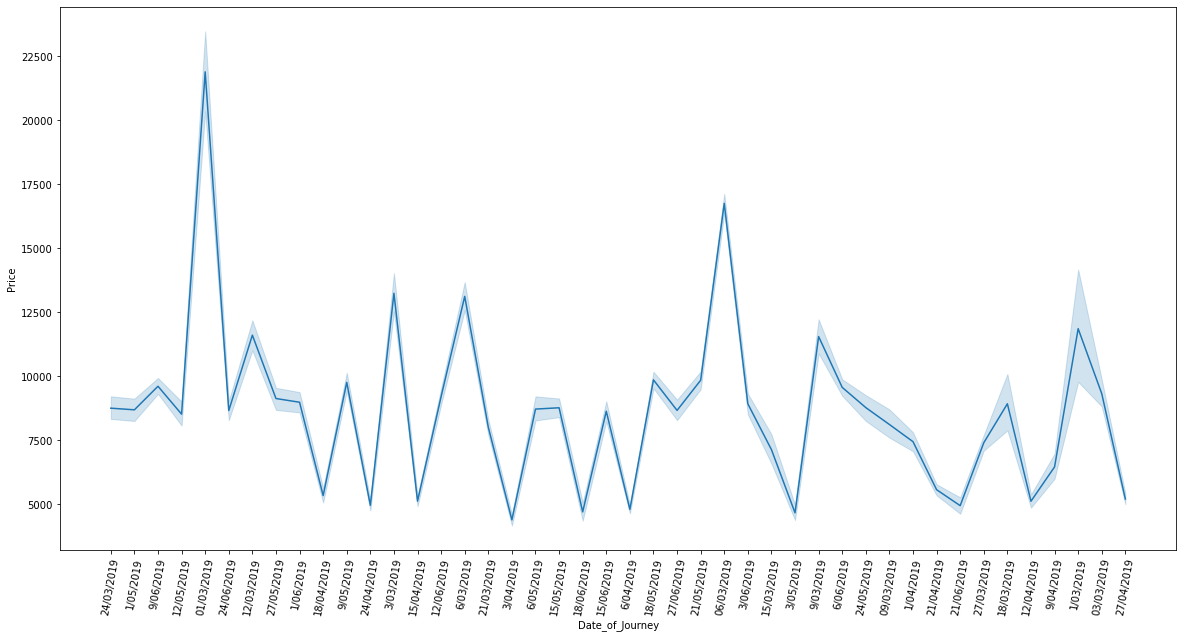

In [19]:
plt.figure(figsize=(20,10))
sns.lineplot(x="Date_of_Journey", y="Price", data=df)
plt.xticks(rotation=80)
plt.show()

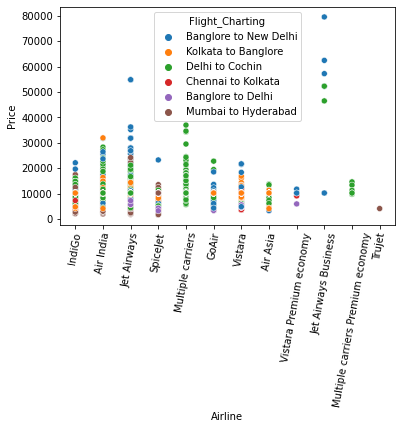

In [44]:
sns.scatterplot(x='Airline',y='Price',data=df3,hue='Flight_Charting')
plt.xticks(rotation=80)
plt.show()

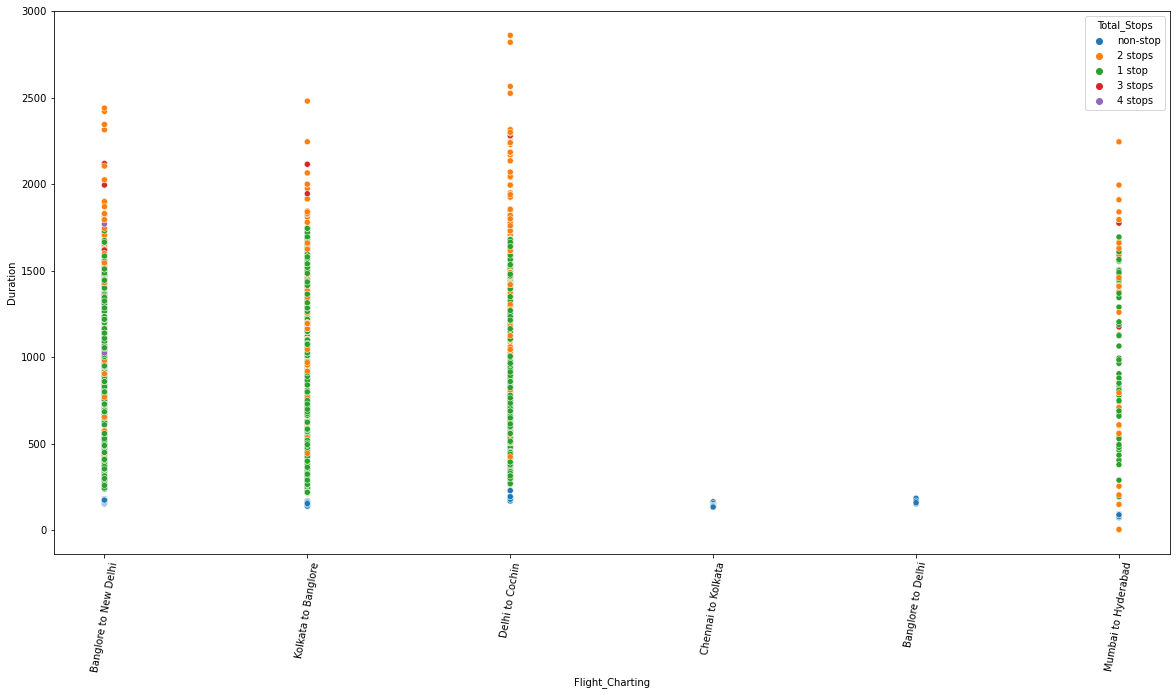

In [51]:
plt.figure(figsize=(20,10))
sns.scatterplot(y='Duration',x='Flight_Charting',data=df3,hue ='Total_Stops' )
plt.xticks(rotation=80)
plt.show()

<Figure size 1440x720 with 0 Axes>

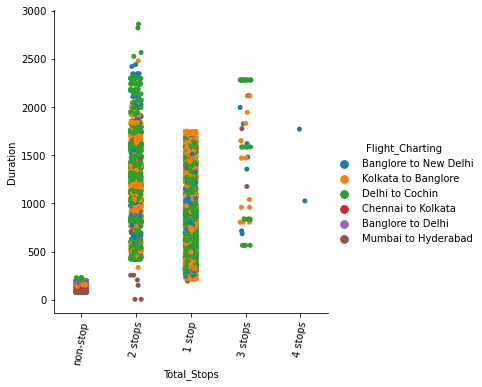

In [65]:
plt.figure(figsize=(20,10))
sns.catplot(x='Total_Stops',y='Duration',data=df3 ,hue='Flight_Charting')
plt.xticks(rotation=80)
plt.show()

<Figure size 1080x432 with 0 Axes>

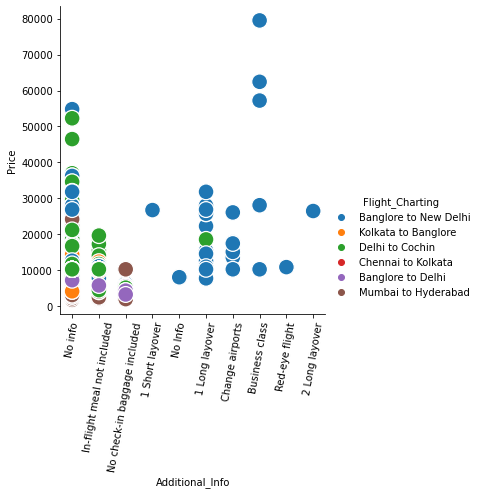

In [80]:
plt.figure(figsize=(15,6))
sns.relplot(x='Additional_Info',y='Price',data=df3,hue= 'Flight_Charting',s=250)
plt.xticks(rotation=80)
plt.show()

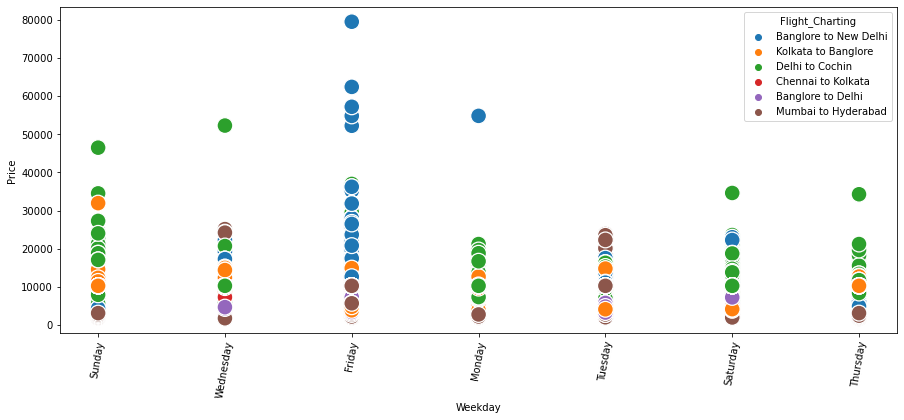

In [86]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='Weekday',y='Price',data=df3,hue= 'Flight_Charting',s=250)
plt.xticks(rotation=80)
plt.show()

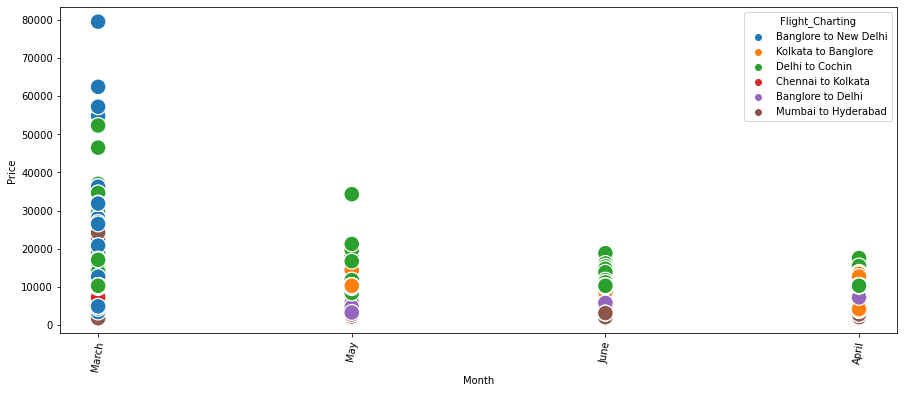

In [85]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='Month',y='Price',data=df3,hue= 'Flight_Charting',s=250)
plt.xticks(rotation=80)
plt.show()

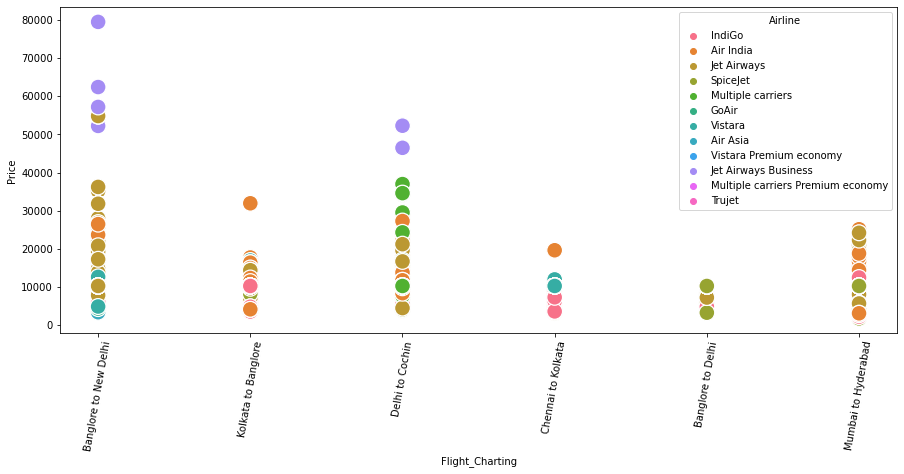

In [87]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='Flight_Charting',y='Price',data=df3,hue= 'Airline',s=250)
plt.xticks(rotation=80)
plt.show()

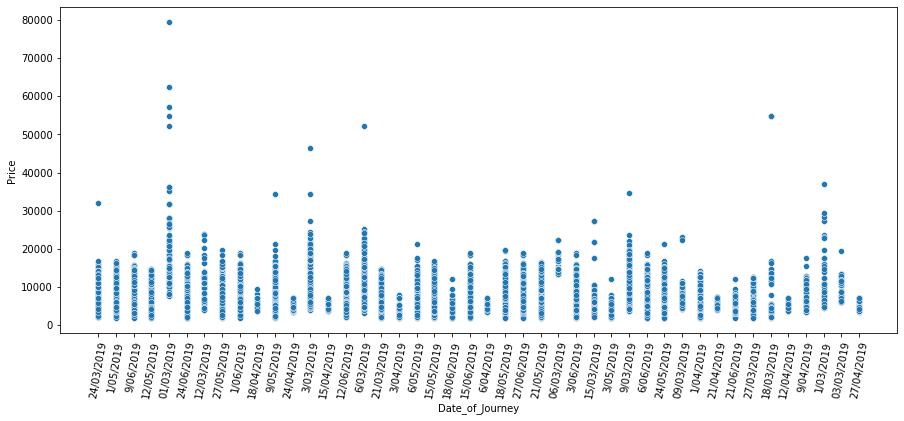

In [103]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='Date_of_Journey',y='Price',data=df1)
plt.xticks(rotation=80)
plt.show()

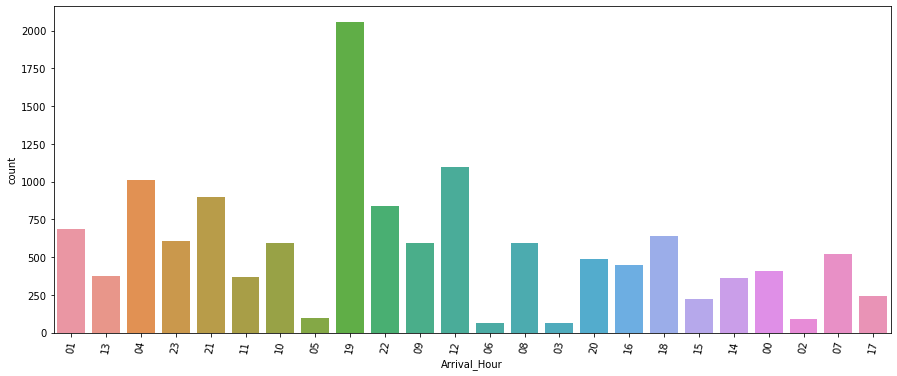

In [107]:
plt.figure(figsize=(15,6))
sns.countplot(x='Arrival_Hour',data=df3)
plt.xticks(rotation=80)
plt.show()

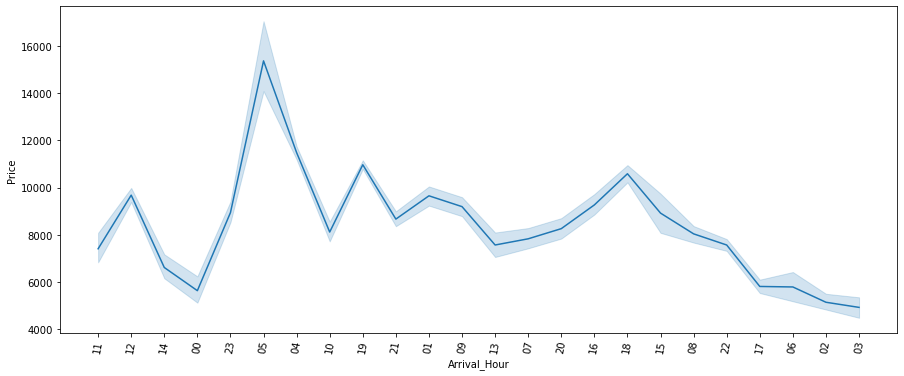

In [154]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Arrival_Hour',y='Price',data=df3.sort_values("Price", ascending = False),)
plt.xticks(rotation=80)
plt.show()

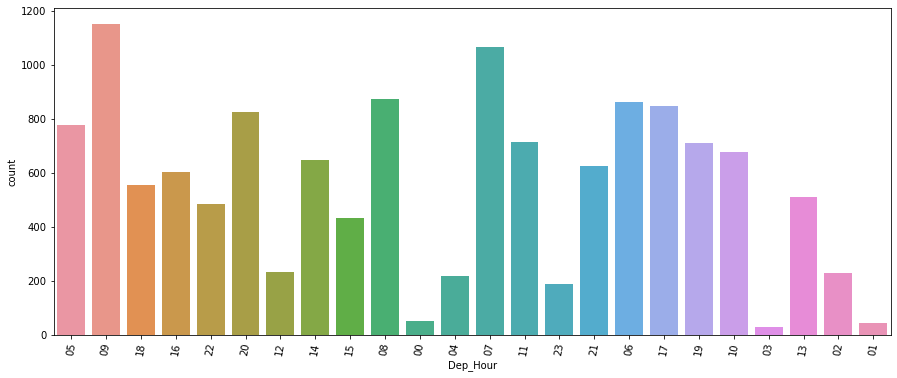

In [153]:
plt.figure(figsize=(15,6))
sns.countplot(x='Dep_Hour',data=df3.sort_values("Price", ascending = False))
plt.xticks(rotation=80)
plt.show()

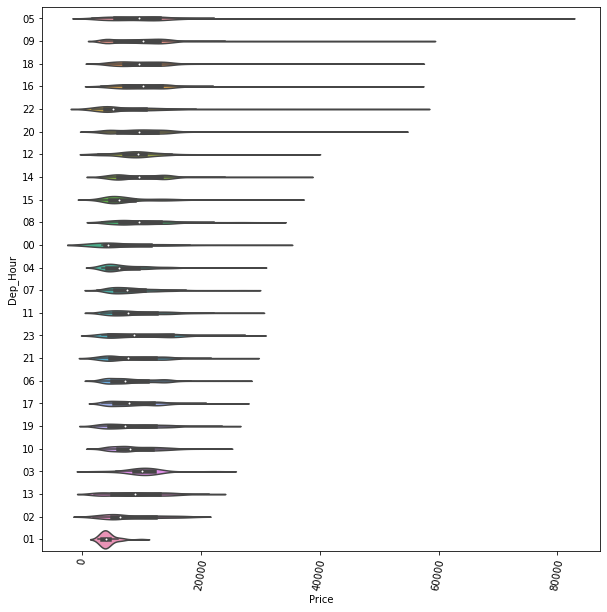

In [152]:
plt.figure(figsize=(10,10))
sns.violinplot(y='Dep_Hour',x='Price',data=df3.sort_values("Price", ascending = False),)
plt.xticks(rotation=80)
plt.show()

In [129]:
df3.groupby('Dep_Hour')['Price'].mean()

Dep_Hour
00    8185.980392 
01    5294.431818 
02    8694.662281 
03    10432.100000
04    7925.374429 
05    9791.864691 
06    8711.657010 
07    8827.112465 
08    10119.181193
09    9768.857639 
10    9205.636632 
11    9472.441176 
12    9486.758621 
13    9284.418787 
14    9974.256569 
15    8356.445476 
16    10307.683775
17    9010.613932 
18    10080.405063
19    8842.760563 
20    9795.876513 
21    8840.094400 
22    8348.026749 
23    9590.544974 
Name: Price, dtype: float64

In [130]:
df3.groupby('Arrival_Hour')['Price'].mean()

Arrival_Hour
00    6642.788321 
01    9797.251453 
02    5873.967391 
03    6157.311475 
04    11274.368213
05    13971.915789
06    6636.156250 
07    8310.424710 
08    8505.813131 
09    9381.079526 
10    8546.209106 
11    7938.219178 
12    9790.508676 
13    8037.677419 
14    7280.394444 
15    9166.238739 
16    9446.287305 
17    6756.623967 
18    10526.392187
19    10823.824988
20    8724.372188 
21    9017.459911 
22    8184.989247 
23    9212.532895 
Name: Price, dtype: float64

In [10]:
df3.select_dtypes(exclude=['int']).columns

Index(['Airline', 'Total_Stops', 'Additional_Info', 'Price', 'Weekday',
       'Month', 'Flight_Charting', 'Arrival_Hour', 'Dep_Hour', 'Day'],
      dtype='object')

In [11]:
category = ['Airline', 'Total_Stops', 'Additional_Info', 'Price', 'Weekday',
       'Month', 'Flight_Charting', 'Arrival_Hour', 'Dep_Hour', 'Day']
lab = LabelEncoder()
for i in category:
    df3[i] = lab.fit_transform(df3[i])

print(df3.dtypes)

Airline            int32
Duration           int64
Total_Stops        int32
Additional_Info    int32
Price              int64
Weekday            int32
Month              int32
Flight_Charting    int32
Arrival_Hour       int32
Dep_Hour           int32
Day                int32
dtype: object


In [157]:
df3.corr()

,Airline,Duration,Total_Stops,Additional_Info,Price,Weekday,Month,Flight_Charting,Arrival_Hour,Dep_Hour,Day
Airline,1.000000,-0.163077,0.037978,-0.058533,-0.023382,0.005871,-0.008276,-0.023832,-0.007831,-0.026127,0.023608
Duration,-0.163077,1.000000,-0.599516,-0.165308,0.409903,0.091414,0.122393,0.212950,0.050745,-0.002450,0.019444
Total_Stops,0.037978,-0.599516,1.000000,0.162122,-0.454567,-0.123884,-0.143426,-0.307582,-0.096135,0.045627,-0.036201
Additional_Info,-0.058533,-0.165308,0.162122,1.000000,-0.038934,0.021958,-0.027771,-0.027342,0.022070,-0.054881,0.019316
Price,-0.023382,0.409903,-0.454567,-0.038934,1.000000,0.042853,0.132759,0.108632,0.038498,0.011950,-0.014976
Weekday,0.005871,0.091414,-0.123884,0.021958,0.042853,1.000000,0.052950,0.091046,0.009510,-0.016068,0.017769
Month,-0.008276,0.122393,-0.143426,-0.027771,0.132759,0.052950,1.000000,0.136159,0.015897,0.014422,-0.010675
Flight_Charting,-0.023832,0.212950,-0.307582,-0.027342,0.108632,0.091046,0.136159,1.000000,0.024497,0.046057,0.151704
Arrival_Hour,-0.007831,0.050745,-0.096135,0.022070,0.038498,0.009510,0.015897,0.024497,1.000000,0.004296,-0.009550
Dep_Hour,-0.026127,-0.002450,0.045627,-0.054881,0.011950,-0.016068,0.014422,0.046057,0.004296,1.000000,-0.007236


<AxesSubplot:>

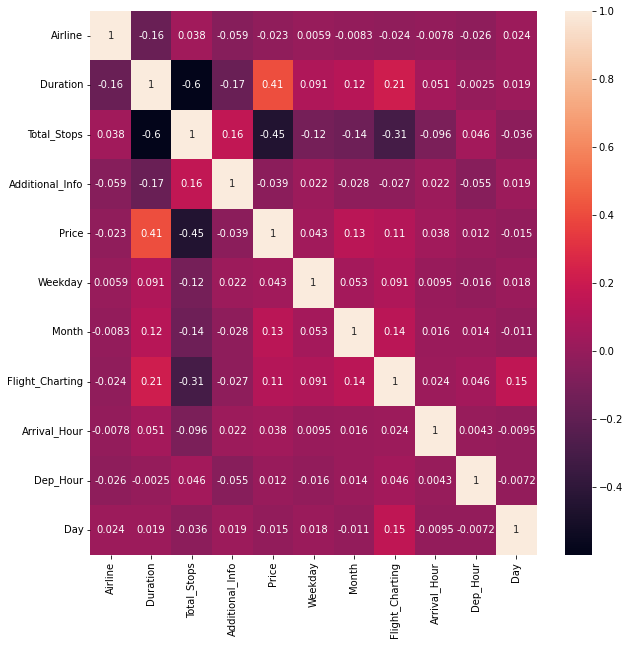

In [158]:
plt.figure(figsize=(10,10))
sns.heatmap(df3.corr(),annot=True)

In [12]:
Columns = ['Airline', 'Duration', 'Total_Stops', 'Additional_Info', 'Price',
       'Weekday', 'Month', 'Flight_Charting', 'Arrival_Hour', 'Dep_Hour',
       'Day']

In [13]:
for i in Columns:
    Q1,Q3 = np.percentile(df3[i] , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    df_no_outliers = df3[(df3[i] < lower_range) | (df3[i] > upper_range)]

In [14]:
z = np.abs(zscore(df3))
threshold = 3
print(np.where(z<3))
print(df3.shape)

(array([    0,     0,     0, ..., 13353, 13353, 13353], dtype=int64), array([ 0,  1,  2, ...,  8,  9, 10], dtype=int64))
(13354, 11)


In [15]:
df_new = df3[(z<3).all(axis = 1)]
df_new.shape

(13243, 11)

In [166]:
df_no_outliers

,Airline,Duration,Total_Stops,Additional_Info,Price,Weekday,Month,Flight_Charting,Arrival_Hour,Dep_Hour,Day


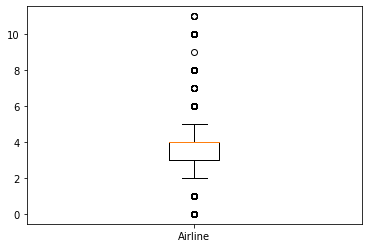

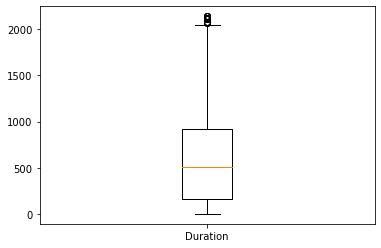

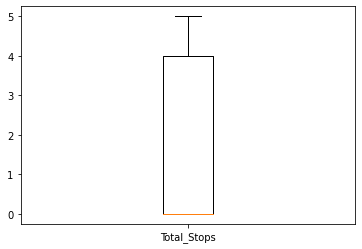

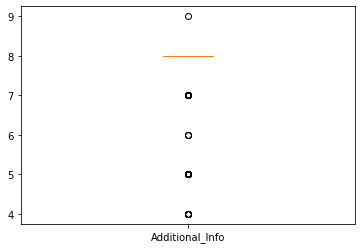

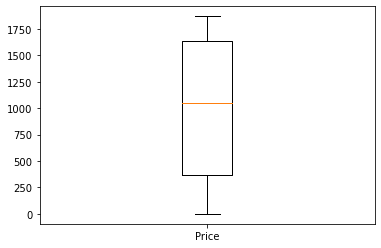

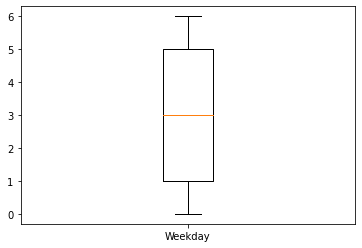

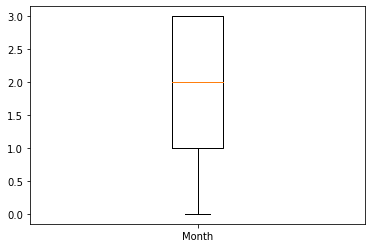

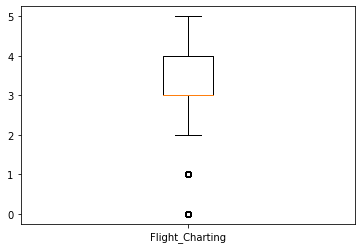

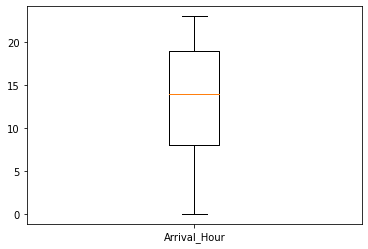

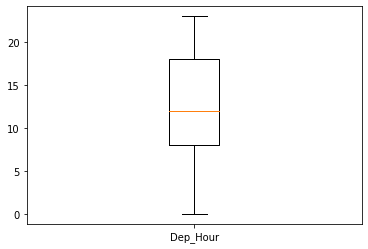

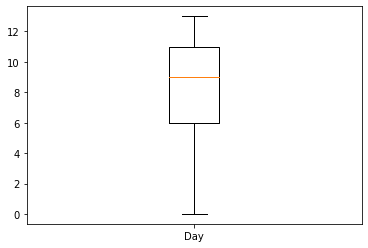

In [170]:
for i in Columns:
    plt.boxplot(df_new[i], labels = [i])
    plt.show()

In [171]:
df3.skew()

Airline            0.720924
Duration           0.867883
Total_Stops        0.639492
Additional_Info   -1.784752
Price             -0.115622
Weekday            0.051702
Month             -0.193885
Flight_Charting   -0.792095
Arrival_Hour      -0.384591
Dep_Hour           0.109087
Day               -0.297426
dtype: float64

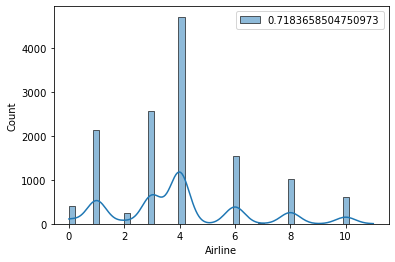

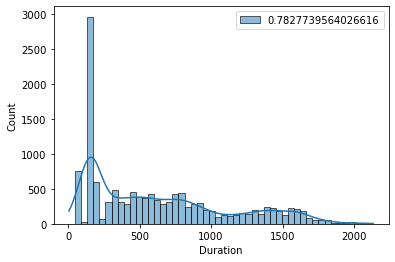

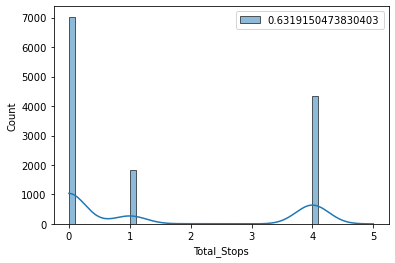

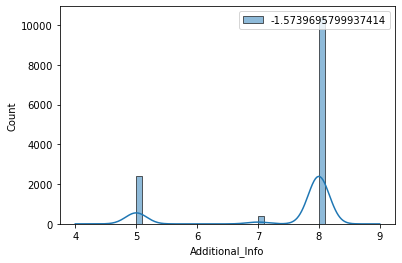

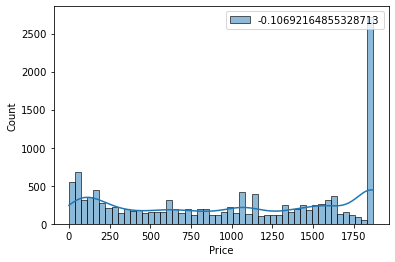

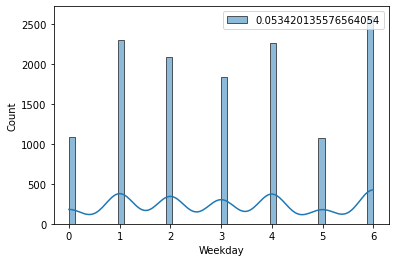

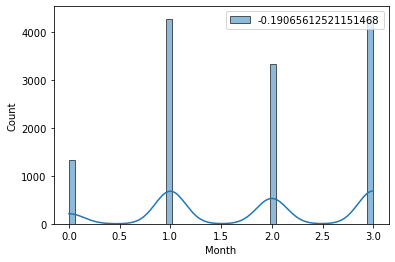

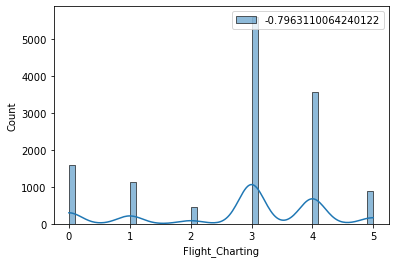

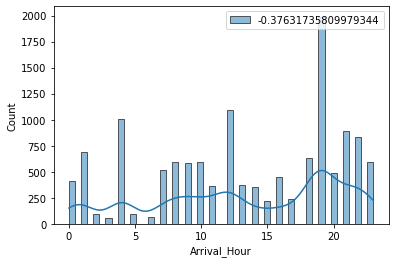

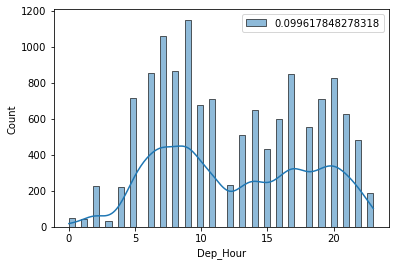

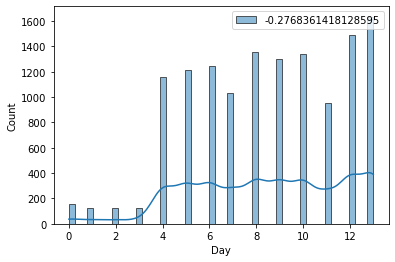

In [174]:
for i in Columns:
    sns.histplot(df_new[i], kde = True, bins = 50, label = df_new[i].skew())
    plt.legend(loc = 'upper right')
    plt.show()

In [40]:
df3.columns

Index(['Airline', 'Duration', 'Total_Stops', 'Additional_Info', 'Price',
       'Weekday', 'Month', 'Flight_Charting', 'Arrival_Hour', 'Dep_Hour',
       'Day'],
      dtype='object')

In [16]:
X = df_new.drop(['Price'],axis=1).iloc[:10683]
y = df_new['Price'].iloc[:10683]

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
for i in X.columns:
    scaler = StandardScaler()
    X[i] = scaler.fit_transform(X[i].values.reshape(-1, 1))

In [20]:
reg_model = [LinearRegression(),GradientBoostingRegressor(),AdaBoostRegressor(),DecisionTreeRegressor(),KNeighborsRegressor(),ExtraTreesRegressor(),RandomForestRegressor()]
max_r2_score = 0
for r_state in range(42,95):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = r_state,test_size = 0.33)
    for i in reg_model:
        i.fit(X_train,y_train)
        pred = i.predict(X_test)
        r2_scores = r2_score(y_test,pred)
        print("R2 score for the random state is" ,r_state ,"is", r2_scores)
        if r2_scores > max_r2_score:
            max_r2_score = r2_scores
            final_state = r_state
            final_model = i
print()
print()
print()
print()
print("Maximum R2 score in the random state " ,final_state , "is" , max_r2_score ,"and model is",final_model)

R2 score for the random state is 42 is 0.5026517035198756
R2 score for the random state is 42 is 0.8199915685093374
R2 score for the random state is 42 is 0.6269307457050164
R2 score for the random state is 42 is 0.7909461418384902
R2 score for the random state is 42 is 0.7419059630355888
R2 score for the random state is 42 is 0.8859094238385242
R2 score for the random state is 42 is 0.8917553282666112
R2 score for the random state is 43 is 0.49808769282726606
R2 score for the random state is 43 is 0.82172603917803
R2 score for the random state is 43 is 0.6348580272314406
R2 score for the random state is 43 is 0.8216485836077809
R2 score for the random state is 43 is 0.7318888744234848
R2 score for the random state is 43 is 0.8850266131080273
R2 score for the random state is 43 is 0.8911411704919664
R2 score for the random state is 44 is 0.510919067343284
R2 score for the random state is 44 is 0.8267578328268315
R2 score for the random state is 44 is 0.6355085846503502
R2 score for the

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10,14]
min_samples_leaf = [1, 2, 4,6,8]

In [22]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8]}


In [23]:
RFR=RandomForestRegressor()
RandomizedSearch_RFR=RandomizedSearchCV(estimator=RFR,param_distributions=param_grid,n_iter=100,cv=3,verbose=2,
                               random_state=74,n_jobs=-1)
RandomizedSearch_RFR.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=74, verbose=2)

In [24]:
RandomizedSearch_RFR.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 450}

In [25]:
RandomizedSearch_RFR.best_estimator_

RandomForestRegressor(max_depth=450, max_features='auto', min_samples_split=5,
                      n_estimators=800)

In [26]:
RFR = RandomForestRegressor(n_estimators=800,min_samples_split=5,min_samples_leaf=1,max_features='auto',max_depth=450,random_state=74)
RFR.fit(X_train,y_train)
pred = RFR.predict(X_test)
r2_scores = r2_score(y_test,pred)
print("R2 Score :",r2_scores*100)

R2 Score : 90.44933694921454


In [27]:
print('Mean Absolute Error: ', mean_absolute_error(y_test,pred))
print('Mean squared Error: ', mean_squared_error(y_test,pred))
print('Root Mean Absolute Error: ', np.sqrt(mean_absolute_error(y_test,pred)))

Mean Absolute Error:  104.0061826878119
Mean squared Error:  31161.776042431975
Root Mean Absolute Error:  10.198342153890106


Text(0, 0.5, 'Predicted_Y')

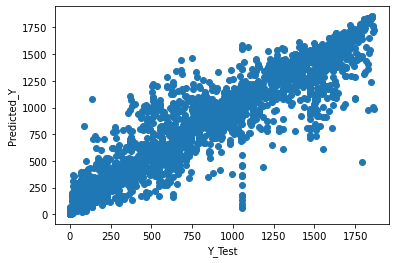

In [28]:
plt.scatter(x=y_test,y=pred)
plt.xlabel('Y_Test')
plt.ylabel('Predicted_Y')

<AxesSubplot:>

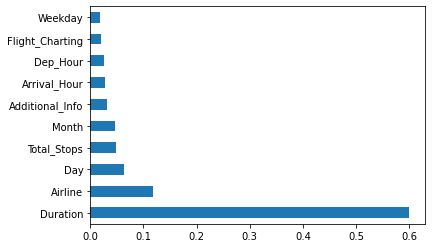

In [34]:
feat_importances = pd.Series(RFR.feature_importances_, index=X_train.columns)
feat_importances.nlargest(11).plot(kind='barh')

In [42]:
from sklearn.pipeline import Pipeline,make_pipeline
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=5)),
                     ('lr_classifier',LinearRegression())])

In [43]:
pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=5)),
                     ('rf_classifier',RandomForestRegressor())])

In [44]:
pipelines = [pipeline_lr, pipeline_dt]

In [45]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [46]:
pipe_dict = {0: 'Linear Regression',1:'RandomForest'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [47]:
pred = pipe.predict(X_test)
r2_scores = r2_score(y_test,pred)
print("R2 Score :",r2_scores*100)

R2 Score : 66.57982375770904


In [189]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [190]:
classification_model = [DecisionTreeClassifier(),KNeighborsClassifier()]
max_accuracy_score = 0
for r_state in range(40,90):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = r_state,test_size = 0.33)
    for j in classification_model:
        j.fit(X_train,y_train)
        pred_c = j.predict(X_test)
        ac_score = accuracy_score(y_test,pred_c)
        print("accuracy score correspond to random state " ,r_state ,"is", ac_score)
        if ac_score> max_accuracy_score:
            max_accuracy_score=ac_score
            final_state = r_state
            final_model_classification = j
            
print()
print()
print()
print()

print("max accuracy score correspond to random state " ,final_state , "is" , max_accuracy_score ,"and model is",final_model_classification)

accuracy score correspond to random state  40 is 0.48581962563811687
accuracy score correspond to random state  40 is 0.2892796369824163
accuracy score correspond to random state  41 is 0.4968803176403857
accuracy score correspond to random state  41 is 0.290414066931367
accuracy score correspond to random state  42 is 0.49035734543391946
accuracy score correspond to random state  42 is 0.2892796369824163
accuracy score correspond to random state  43 is 0.49602949517867273
accuracy score correspond to random state  43 is 0.28389109472490076
accuracy score correspond to random state  44 is 0.4784458309699376
accuracy score correspond to random state  44 is 0.29126488939308
accuracy score correspond to random state  45 is 0.4824163357912649
accuracy score correspond to random state  45 is 0.2872943845717527
accuracy score correspond to random state  46 is 0.4968803176403857
accuracy score correspond to random state  46 is 0.30005672149744755
accuracy score correspond to random state  47 

In [191]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [192]:
dec = DecisionTreeClassifier(random_state=86)
grid_search = GridSearchCV(estimator=dec, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [193]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=86), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [194]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=86)

In [195]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}

In [196]:
DTC = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=5, random_state=86)
DTC.fit(X_train,y_train)
predc = DTC.predict(X_test)
acurracy_score = accuracy_score(y_test,predc)
print("Accuracy Score :",acurracy_score*100)

Accuracy Score : 45.91605218377765


In [247]:
tes = df3.iloc[10683:]

In [248]:
Test_data = tes.drop('Price',axis=1)

In [249]:
test_da = tes.drop(['Price'],axis=1)

In [250]:
for i in test_da.columns:
    scaler = StandardScaler()
    test_da[i] = scaler.fit_transform(test_da[i].values.reshape(-1, 1))

In [251]:
test_da.shape

(2671, 10)

In [252]:
RFR = RandomForestRegressor(n_estimators=560,min_samples_split=5,min_samples_leaf=1,max_features='auto',max_depth=560,random_state=74)
RFR.fit(X_train,y_train)
pred = RFR.predict(test_da)


In [254]:
Price = pd.DataFrame(pred).reset_index()

In [257]:
Test = pd.DataFrame(test_da).reset_index()

In [258]:
Flight_Price = pd.concat([Test,Price],axis=1)
Flight_Price

,index,Airline,Duration,Total_Stops,Additional_Info,Weekday,Month,Flight_Charting,Arrival_Hour,Dep_Hour,Day,index,0
0,10683,-0.009009,0.030389,-0.792411,0.471706,0.412824,-0.816993,0.111967,-1.361709,0.773265,1.100503,0,1605.040621
1,10684,-0.423903,-0.796151,-0.792411,0.471706,-0.098373,1.197954,0.824026,-0.509324,-1.161445,-1.041949,1,866.042428
2,10685,-0.009009,1.563970,-0.792411,-2.180771,0.924021,1.197954,0.111967,0.769252,1.125030,-0.123755,2,1467.389881
3,10686,0.820778,0.279347,-0.792411,0.471706,0.924021,1.197954,0.111967,1.053380,-0.809679,-0.123755,3,1253.601487
4,10687,-1.668584,-0.935567,1.435515,0.471706,-1.120768,-0.816993,-2.024209,-1.645837,1.828561,0.182310,4,170.659465
5,10688,-0.009009,0.916680,-0.792411,-2.180771,1.435218,-0.816993,0.111967,-0.225196,0.949147,-1.041949,5,1389.584208
6,10689,-1.253690,0.528305,-0.792411,0.471706,0.924021,0.190481,-1.312150,1.195444,-0.985562,-1.041949,6,1067.400389
7,10690,-0.423903,-0.646776,-0.792411,0.471706,1.435218,1.197954,0.824026,0.911316,0.421499,-1.348014,7,322.492589
8,10691,-0.423903,-0.945526,1.435515,0.471706,-1.631965,0.190481,0.824026,-0.225196,-0.457914,-0.735884,8,174.818082
9,10692,-0.009009,-0.547193,-0.792411,0.471706,-0.609571,1.197954,0.824026,1.195444,0.597382,-0.429820,9,1693.154550
